In [1]:
import pandas as pd
import numpy as np
import anndata as ann
import scanpy as sc
import os, sys
from scipy.stats import pearsonr as pr
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score as f1
from sklearn.metrics import precision_recall_curve as prc
from sklearn.metrics import silhouette_score as sil
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, average_precision_score


In [2]:
sc.set_figure_params(dpi=400)

# Load Anndata

In [3]:
# load data
adata = sc.read('METMAP500.h5ad')
adata

/home/wang3712/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 259 × 1512
    obs: 'Tissue', 'prim_or_metas', 'metas_site'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'

In [4]:
# reformat the tissue as just the name
from collections import Counter
all_tissues = adata.obs['Tissue'].unique()
new_tissues = []
for tissue in adata.obs['Tissue']:
    if tissue.startswith('CNS/BRAIN'):
        new_tissues.append('BRAIN')
    else:
        new_tissues.append(tissue.split('/')[0].split('_')[0])
adata.obs['new_tissue'] = new_tissues
adata.obs['new_tissue'].unique()

array(['BOWEL', 'SKIN', 'LUNG', 'BLADDER', 'BRAIN', 'PANCREAS', 'OVARY',
       'KIDNEY', 'HEAD AND NECK', 'UTERUS', 'LIVER', 'BREAST',
       'ESOPHAGUS'], dtype=object)

/home/wang3712/.local/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/wang3712/.local/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/wang3712/.local/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWarning:

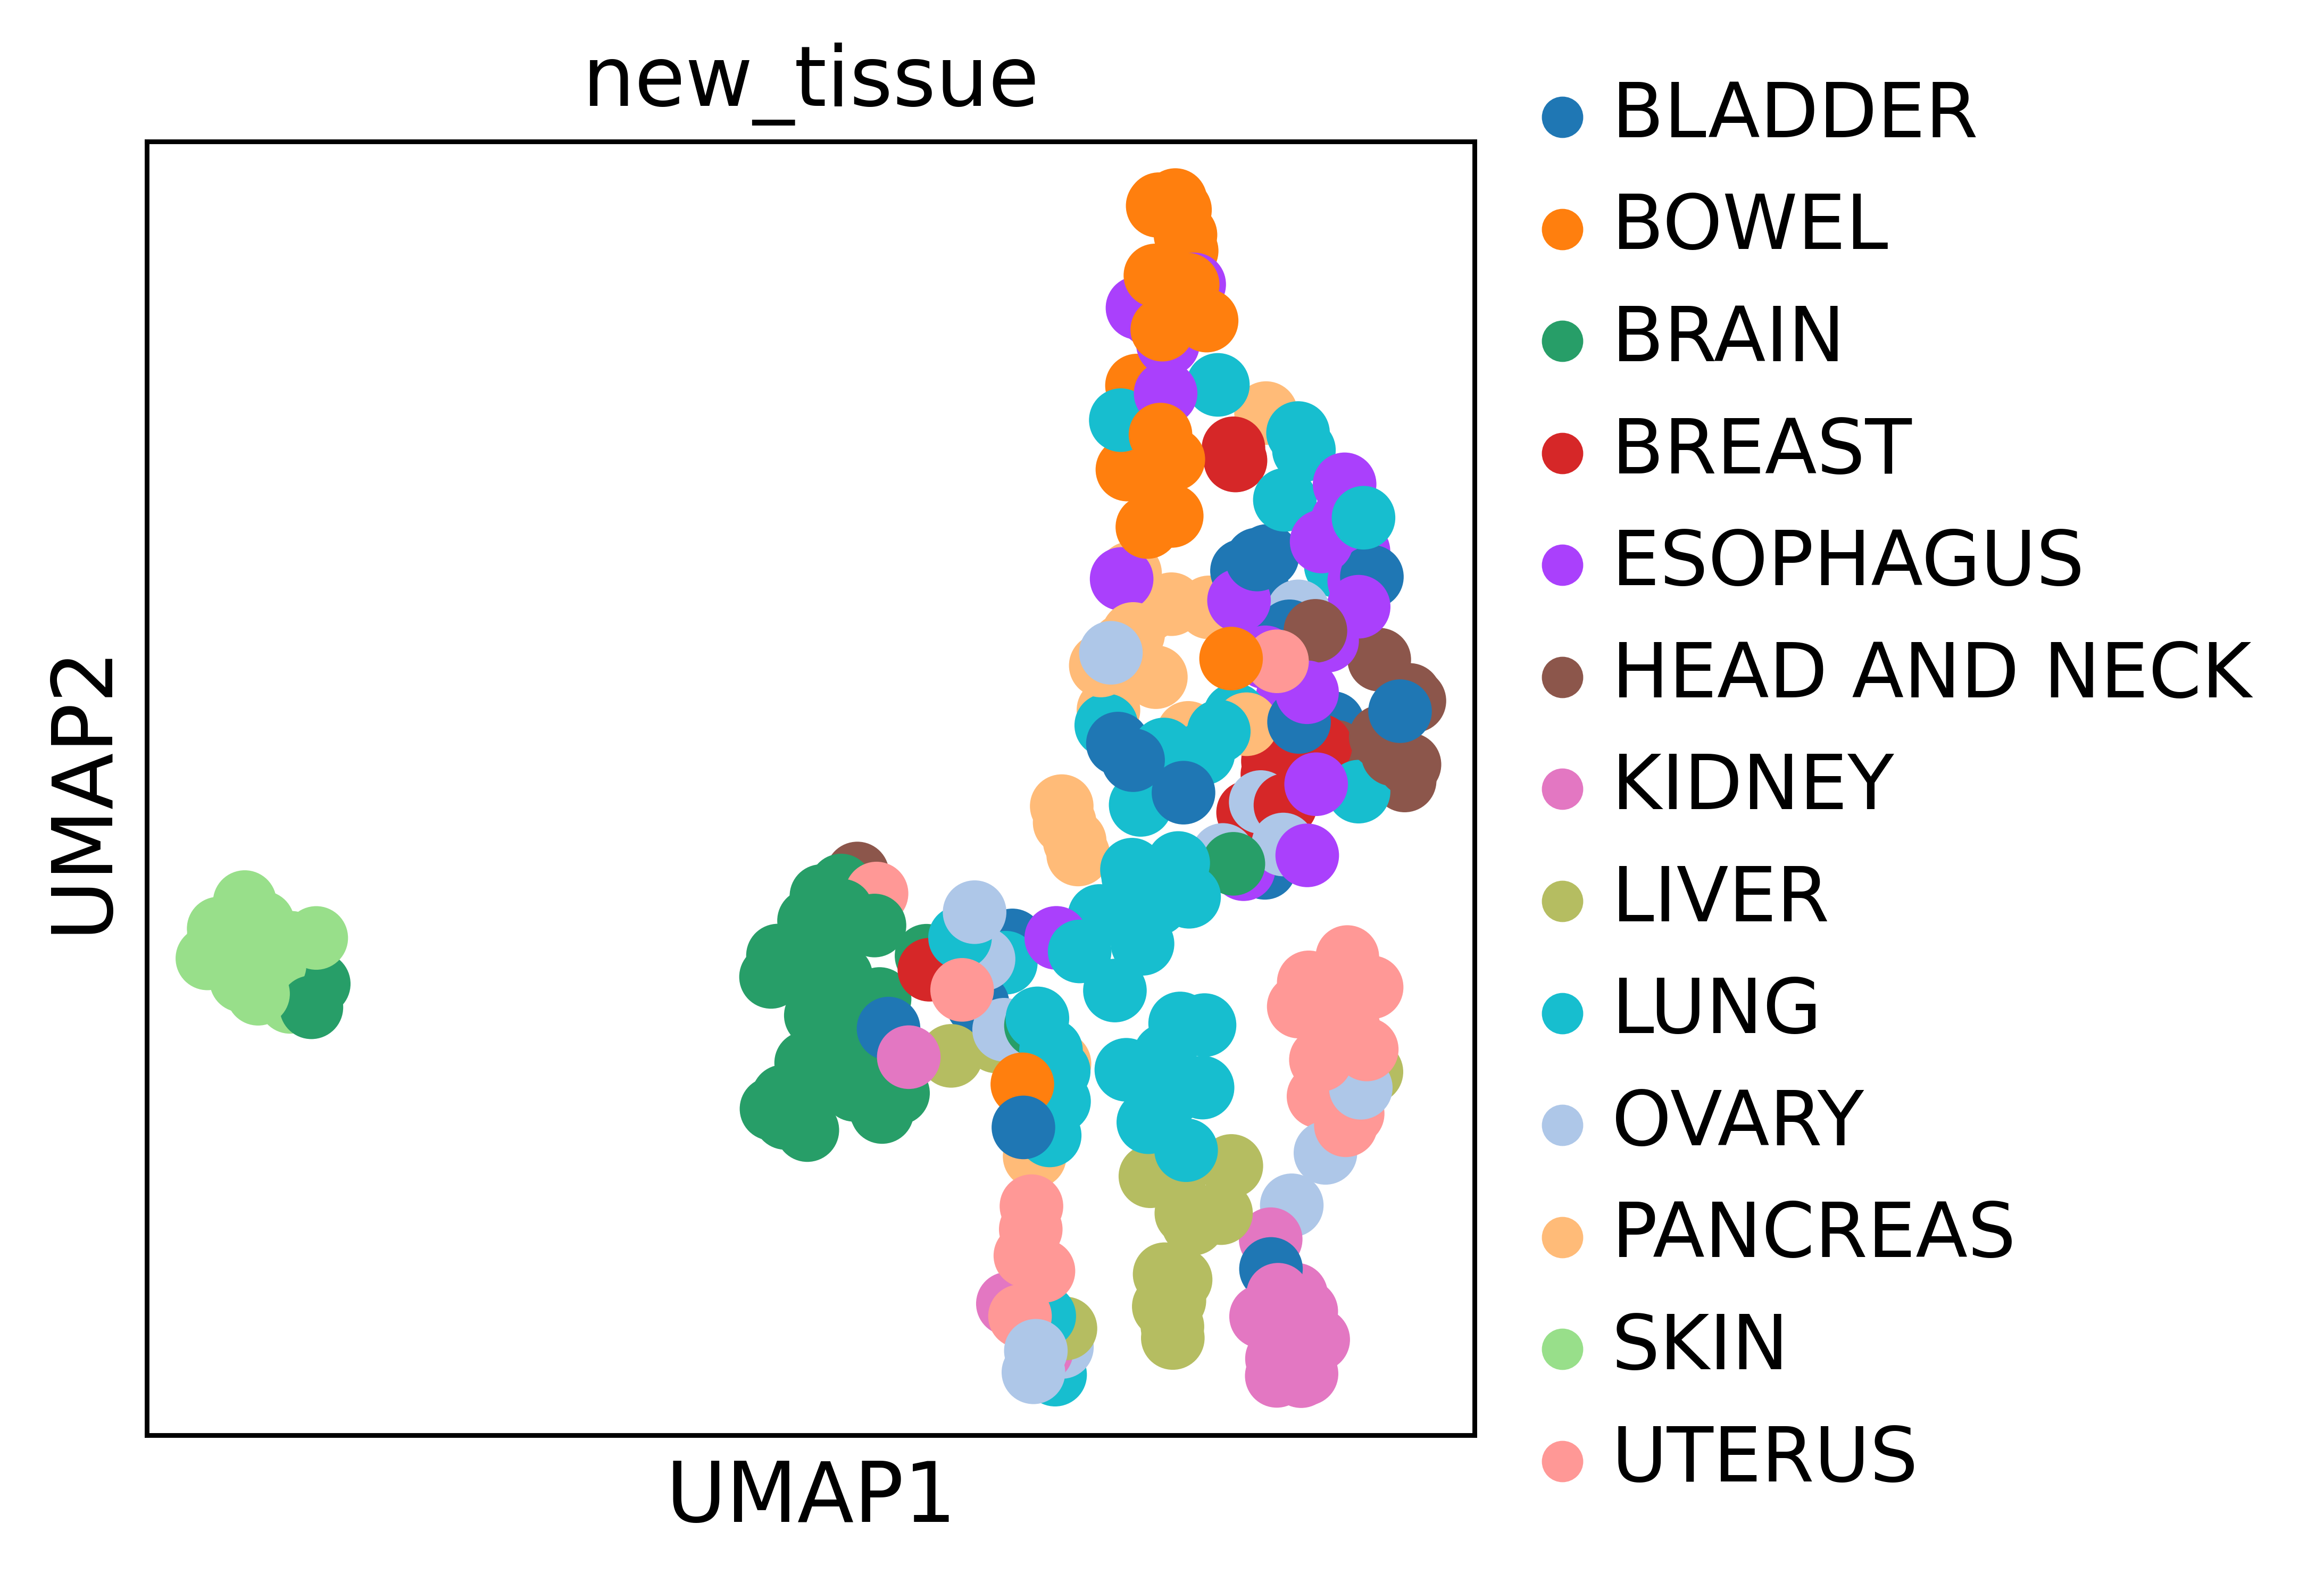

/home/wang3712/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


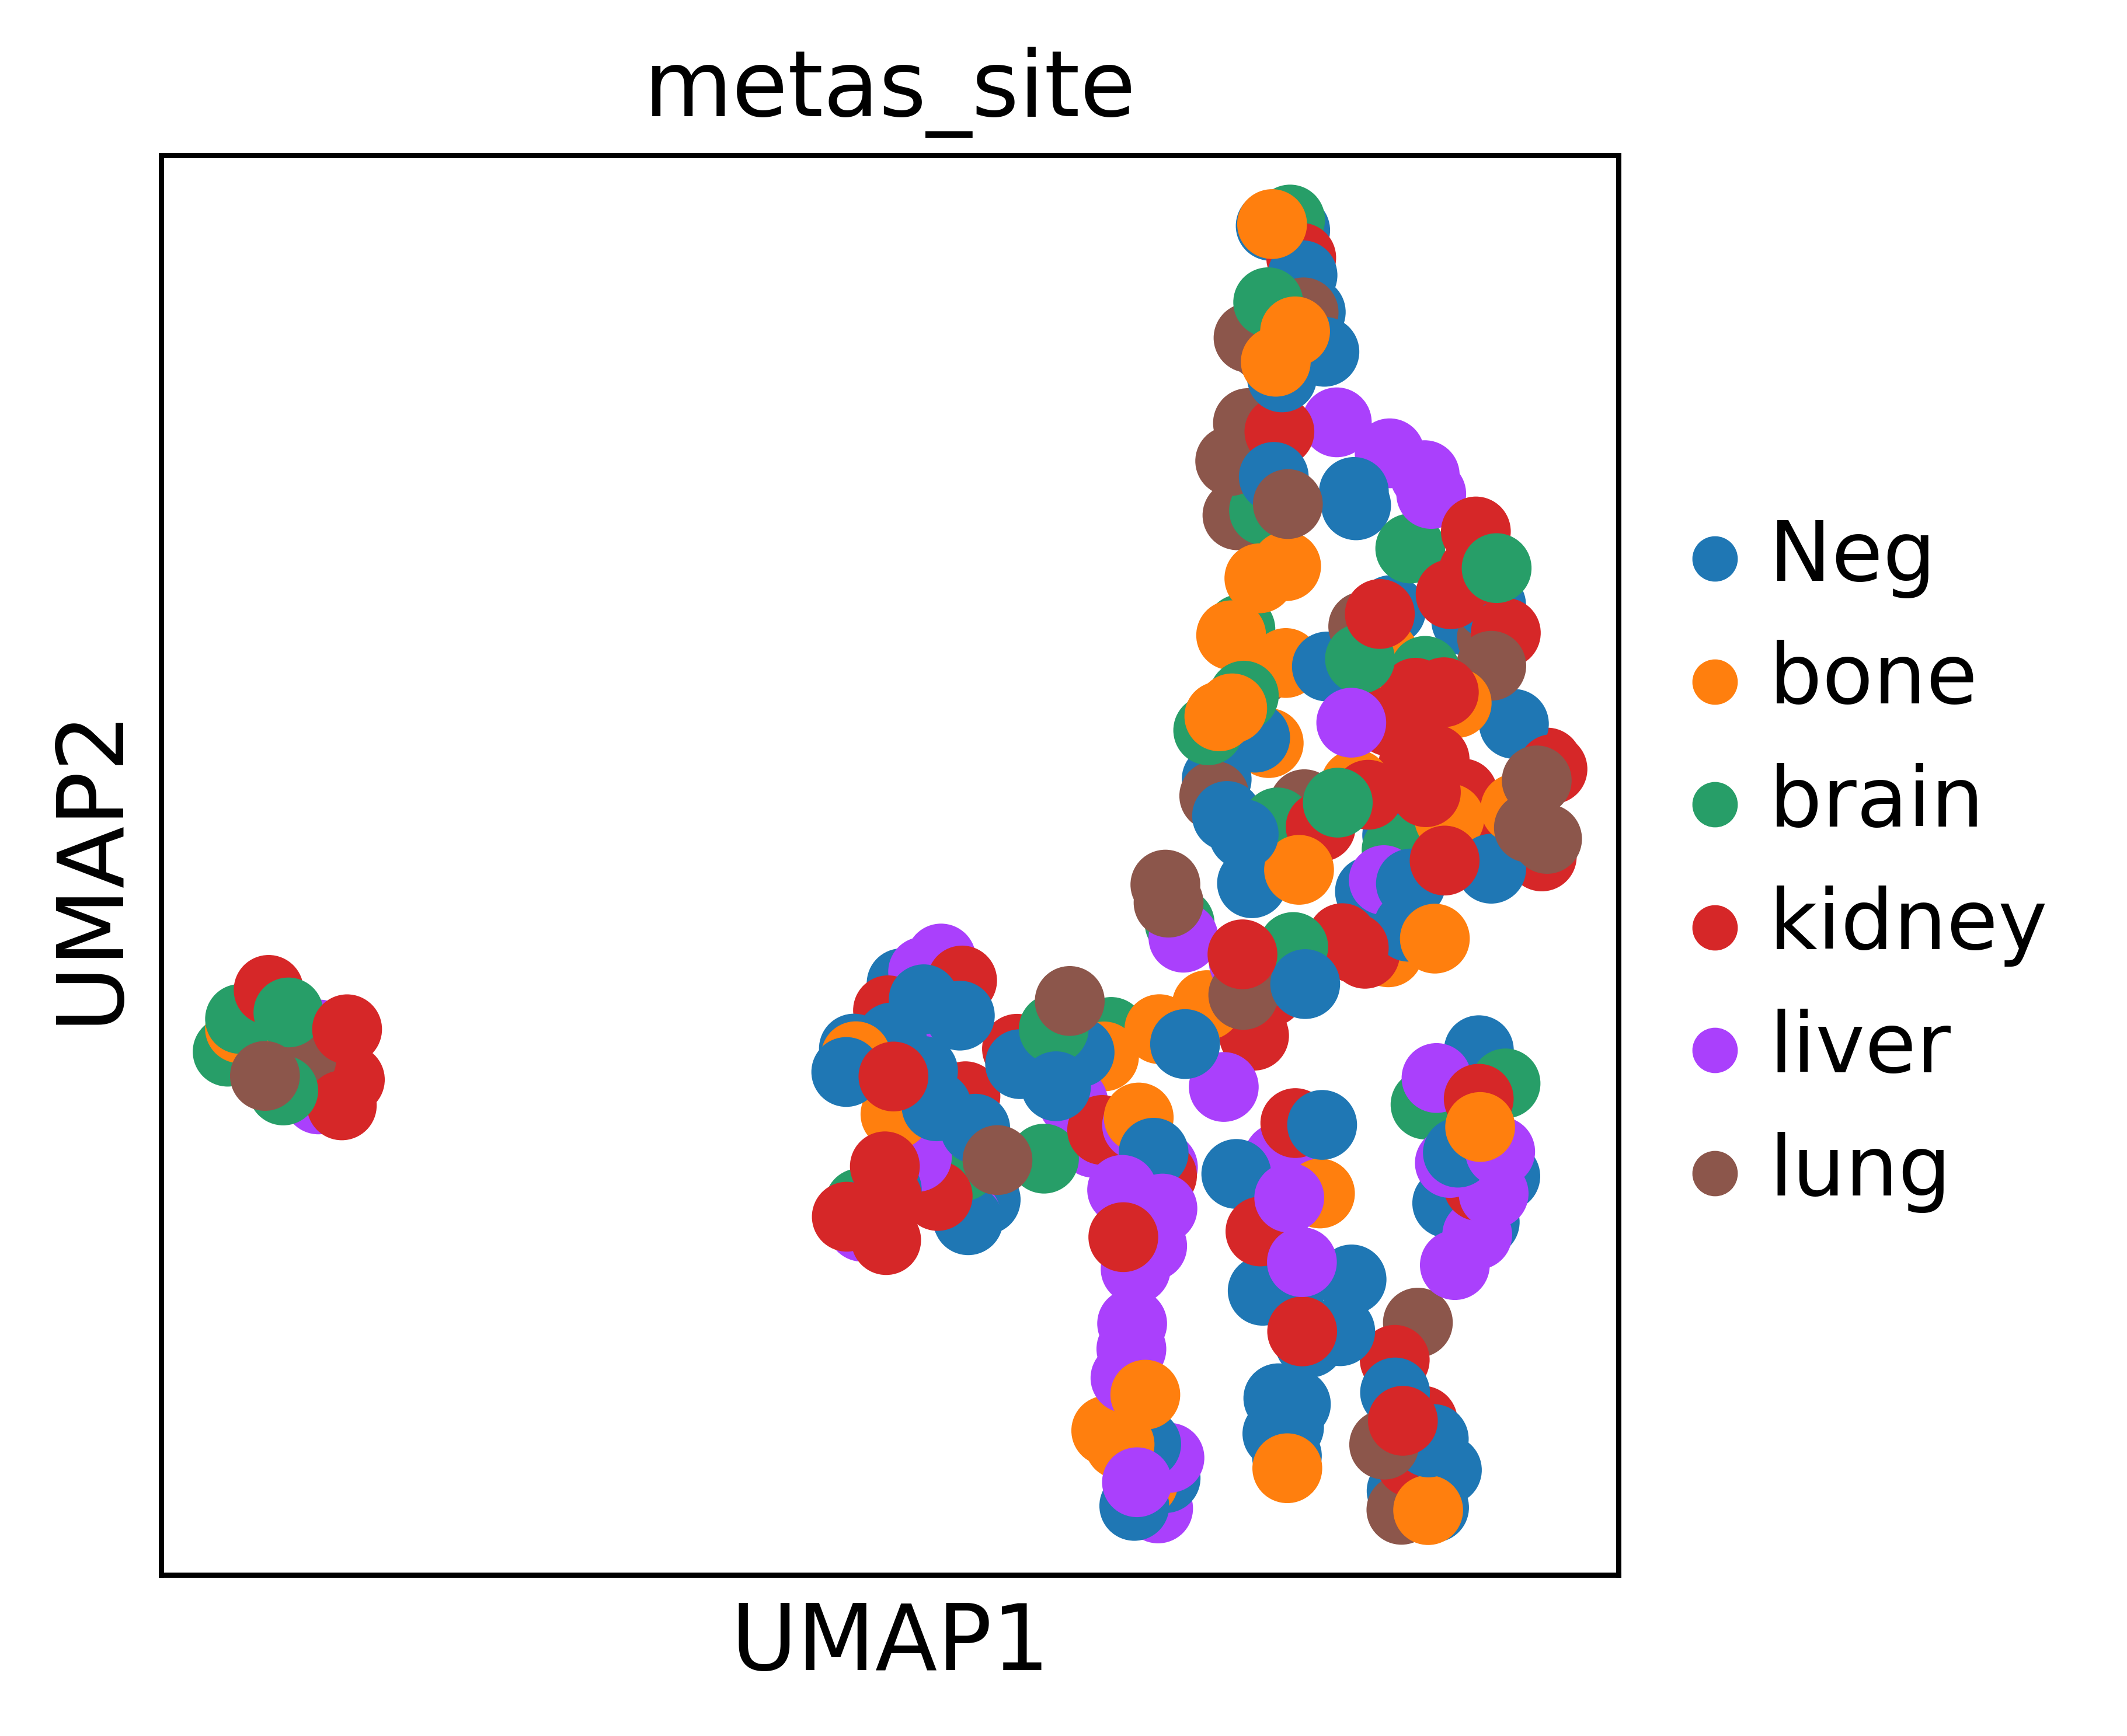

In [5]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='new_tissue')
sc.pl.umap(adata, color='metas_site')


# One hot encoding

In [6]:
# one hot encoding the labels
def one_hot_encode(labels, num_classes):
    unique_labels = list(set(labels))
    
    one_hot_encoded = np.zeros(shape=(len(labels), num_classes))

    # Encode labels by setting the corresponding index to 1 in each row
    for i, label in enumerate(labels):
        index = unique_labels.index(label)
        one_hot_encoded[i, index] = 1

    return one_hot_encoded, unique_labels

In [7]:
one_hot_labels_tissue,_ = one_hot_encode(adata.obs['new_tissue'], len(adata.obs['new_tissue'].unique()))

In [8]:
one_hot_labels_site, uniqe_labels_site = one_hot_encode(adata.obs['metas_site'], len(adata.obs['metas_site'].unique()))

## One vs. All

In [9]:
one_hot_labels_site_one_vs_all = dict()
all_sites = adata.obs.metas_site.value_counts().index
for tissue in all_sites:
    print(tissue)
    tissues_to_learn = tissue
    one_vs_all_labels = []
    for i in adata.obs.metas_site:
        if  i == tissues_to_learn:
            one_vs_all_labels.append(1)
        else:
            one_vs_all_labels.append(0)
    adata.obs[tissue+'.1va'] = one_vs_all_labels
    one_hot_labels_site_one_vs_all[tissue], _ = one_hot_encode(adata.obs[tissue+'.1va'], len(adata.obs[tissue+'.1va'].unique()))

Neg
kidney
liver
bone
lung
brain


In [10]:
adata.obs

,Tissue,prim_or_metas,metas_site,new_tissue,Neg.1va,kidney.1va,liver.1va,bone.1va,lung.1va,brain.1va
ACH-000007,BOWEL,Primary,Neg,BOWEL,1,0,0,0,0,0
ACH-000008,SKIN,Primary,liver,SKIN,0,0,1,0,0,0
ACH-000012,LUNG,Primary,bone,LUNG,0,0,0,1,0,0
ACH-000015,LUNG,Primary,liver,LUNG,0,0,1,0,0,0
ACH-000018,BLADDER/URINARY TRACT,Primary,brain,BLADDER,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
ACH-000996,UTERUS,Primary,bone,UTERUS,0,0,0,1,0,0
ACH-000997,BOWEL,Primary,lung,BOWEL,0,0,0,0,1,0
ACH-001016,CNS/BRAIN,Primary,kidney,BRAIN,0,1,0,0,0,0
ACH-001113,LUNG,Primary,brain,LUNG,0,0,0,0,0,1


# Dataloader

In [11]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split

In [12]:
class GeneExpressionDataset(torch.utils.data.Dataset):
    def __init__(self, data, tumors, metas_sites):
        self.data = data  # gene expression data (shape: N x num_genes)
        self.tumors = tumors  # primary tumor type
        self.site = metas_sites # metastasis sites

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        expression = self.data[idx]  # single gene expression vector
        tumor = self.tumors[idx]  
        site = self.site[idx]
        return expression, tumor, site

In [13]:
# min max normalization
df_normalized = adata.to_df().apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
df_normalized

,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001617,ENSG00000001626,ENSG00000002586,ENSG00000002726,ENSG00000002822,ENSG00000003147,ENSG00000003402,...,ENSG00000259207,ENSG00000261052,ENSG00000264424,ENSG00000271503,ENSG00000275385,ENSG00000275410,ENSG00000275718,ENSG00000275896,ENSG00000277443,ENSG00000277586
ACH-000007,0.001362,0.418544,0.369698,0.106475,0.408904,0.474120,0.458151,0.440864,0.464034,0.260111,...,0.001478,0.279958,0.017318,0.068780,0.000000,0.219731,0.493214,0.421571,0.273935,0.049319
ACH-000008,0.006430,0.477888,0.343918,0.017110,0.016921,0.478341,0.010205,0.480758,0.066012,0.335006,...,0.545344,0.276866,0.001148,0.127957,0.065129,0.003036,0.007540,0.011576,0.222305,0.393855
ACH-000012,0.191250,0.456729,0.308974,0.020991,0.001036,0.381573,0.035220,0.272343,0.308789,0.430792,...,0.112426,0.328580,0.000000,0.033411,0.000000,0.325642,0.004284,0.000000,0.372882,0.002864
ACH-000015,0.257558,0.451050,0.317799,0.103040,0.004082,0.413896,0.000636,0.338382,0.172822,0.322058,...,0.024053,0.230060,0.000000,0.024011,0.000000,0.002155,0.005483,0.000000,0.280227,0.057089
ACH-000018,0.153213,0.479226,0.263913,0.387343,0.000931,0.644546,0.009856,0.399677,0.156312,0.350153,...,0.242461,0.310473,0.000000,0.144101,0.000000,0.274338,0.000000,0.088571,0.421349,0.004805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-000996,0.074882,0.440487,0.295306,0.185086,0.048008,0.288487,0.006353,0.286848,0.340713,0.236046,...,0.164890,0.289611,0.000000,0.085934,0.000000,0.233327,0.004805,0.080224,0.190480,0.000000
ACH-000997,0.003535,0.544124,0.340695,0.161163,0.027014,0.531133,0.003096,0.303902,0.374838,0.413348,...,0.011084,0.287474,0.000000,0.000000,0.000000,0.218204,0.030232,0.003117,0.249225,0.006531
ACH-001016,0.034719,0.436016,0.333444,0.196966,0.012406,0.571435,0.000000,0.319017,0.000000,0.367459,...,0.217110,0.375106,0.000000,0.005349,0.000000,0.000000,0.000000,0.000000,0.490580,0.000862
ACH-001113,0.086371,0.221148,0.484695,0.234437,0.000000,0.387764,0.007274,0.227263,0.124448,0.373009,...,0.076591,0.368189,0.000000,0.019027,0.000000,0.000000,0.000000,0.000000,0.509043,0.410519


# Stratified Five fold CV

In [14]:
all_data = GeneExpressionDataset(torch.tensor(df_normalized.to_numpy(), dtype=torch.float32), 
                                 torch.tensor(one_hot_labels_tissue, dtype=torch.float32),
                                 torch.tensor(one_hot_labels_site, dtype=torch.float32))

In [15]:
from sklearn.model_selection import StratifiedKFold
# import numpy as np


# Convert to class indices
tissue_labels = np.argmax(one_hot_labels_tissue, axis=1)  # Convert one-hot to class indices
site_labels = np.argmax(one_hot_labels_site, axis=1)  # Convert one-hot to class indices

# Prepare StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)  # Use a fixed random_state for repeatability

# Store seeds and indices
cv_splits = []

batch_size = 8

# Iterate through the splits
for fold, (train_idx, val_idx) in enumerate(skf.split(df_normalized.to_numpy(), site_labels)):
    # print(train_idx)
    # print(val_idx)
    print(f'Fold {fold+1}')
    
    # Extract the training and validation data based on the indices
    train_data = torch.utils.data.Subset(all_data, train_idx)
    val_data = torch.utils.data.Subset(all_data, val_idx)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
    
    cv_splits.append({'train_idx': train_idx, 'val_idx': val_idx})
    
    # Check stratification by printing unique labels in the validation set
    val_tissue_labels = np.argmax(one_hot_labels_tissue[val_idx], axis=1)
    val_site_labels = np.argmax(one_hot_labels_site[val_idx], axis=1)
    
    print('Validation Tissue Labels:', np.unique(val_tissue_labels, return_counts=True), len(np.unique(val_tissue_labels)))
    print('Validation Site Labels:', np.unique(val_site_labels, return_counts=True), len(np.unique(val_site_labels)))

Fold 1

Validation Tissue Labels: (array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12]), array([5, 6, 5, 3, 3, 5, 6, 1, 4, 7, 3, 4])) 12
Validation Site Labels: (array([0, 1, 2, 3, 4, 5]), array([11, 15,  8,  5,  7,  6])) 6
Fold 2

Validation Tissue Labels: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([13,  2,  3,  3,  6,  2,  3,  2,  2,  5,  2,  1,  8])) 13
Validation Site Labels: (array([0, 1, 2, 3, 4, 5]), array([11, 15,  8,  5,  7,  6])) 6
Fold 3

Validation Tissue Labels: (array([ 0,  1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([ 9,  2,  5,  4,  2,  2,  2,  3,  7,  4,  2, 10])) 12
Validation Site Labels: (array([0, 1, 2, 3, 4, 5]), array([11, 14,  8,  5,  8,  6])) 6
Fold 4

Validation Tissue Labels: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([9, 2, 7, 4, 5, 2, 3, 3, 5, 2, 4, 1, 5])) 13
Validation Site Labels: (array([0, 1, 2, 3, 4, 5]), array([11, 14,  8,  5,  8,  6])) 6
Fold 5

Validation Tissue Labels: (array([ 0,  1,  2,

# PreMet

## Model

In [16]:
def initialize_weights_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)  # Xavier initialization
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)  # Xavier initialization
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm1d) or isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
        

In [17]:
class Encoder(nn.Module):
    def __init__(self, gene_num, latent_size, hidden_dim=128):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(gene_num, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_size)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_size)
        # Apply Xavier initialization
        self.apply(initialize_weights_xavier)  

        
    def forward(self, x):
        # switch to leaky RELU
        h = F.leaky_relu(self.bn1(self.fc1(x)), negative_slope=0.01)
        mean = self.fc2_mean(h)
        logvar = self.fc2_logvar(h)
        return mean, logvar
    

class Decoder(nn.Module):
    def __init__(self, latent_size, gene_num, hidden_dim=128):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, gene_num)
        # Apply Xavier initialization
        self.apply(initialize_weights_xavier)  
        
    def forward(self, z):
        h = F.leaky_relu(self.bn1(self.fc1(z)))
        reconstructed_x = self.fc2(h)  
        return reconstructed_x



class Primary_tumor_DNN(nn.Module):
    def __init__(self, num_latent, num_classes):
        super(Primary_tumor_DNN, self).__init__()
        self.fc1 = nn.Linear(num_latent, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, num_classes)
        # self.bn2 = nn.BatchNorm1d(128)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.fc2(x)
        #  x = self.fc3(x)  
        return self.softmax(x)


class Metas_site_DNN(nn.Module):
    def __init__(self, num_latent, num_classes):
        super(Metas_site_DNN, self).__init__()
        self.fc1 = nn.Linear(num_latent, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, num_classes)
        # self.bn2 = nn.BatchNorm1d(128)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.fc2(x)
        #  x = self.fc3(x)  
        return self.softmax(x)
    
# Define the VAE

class PreMet(nn.Module):
    def __init__(self, gene_num, latent_size, num_tissues, num_metas_sites, hidden_size):
        super(PreMet, self).__init__()
        self.encoder = Encoder(gene_num, latent_size, hidden_dim=hidden_size)
        self.decoder = Decoder(latent_size, gene_num, hidden_dim=hidden_size)
        self.tissue_nn = Primary_tumor_DNN(latent_size, num_tissues)
        self.site_nn = Metas_site_DNN(latent_size, num_metas_sites)
        
    def reparameterize(self, mean, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mean + eps * std
        else:
            return mean
    
    def forward(self, x):
        mean, logvar = self.encoder(x)
        
        z = self.reparameterize(mean, logvar)
        reconstructed_x = self.decoder(z)
        
        # predict tumor type from latent
        tissue_output = self.tissue_nn(z)
        
        # predict metastasis site from latent
        site_output = self.site_nn(z)
        
        return reconstructed_x, mean, logvar, tissue_output, site_output

## Focal loss

In [130]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Standard Cross Entropy Loss
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)

        # Calculate pt (probability of true class)
        pt = torch.exp(-ce_loss)

        # Focal Loss 
        focal_loss = self.alpha * ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


## Focal Loss Grid Search

In [ ]:
gamma_list = [1,2,3,4,5,6]
alpha_list = [0.25, 0.5, 0.75, 1]
for gamma in gamma_list:
    for alpha in alpha_list:
        print('+'*10, gamma, alpha, '+'*10)
        
        # for tumor type prediction
        criterion_1 = nn.CrossEntropyLoss()
        # for metastasis site prediction
        focal_loss = FocalLoss(alpha=alpha, gamma=gamma)

        def mse_loss(y, recon_y):
            return torch.mean((y - recon_y) ** 2)


        def loss_function_premet(y, recon_y, mean, logvar, 
                                 tissue_labels, pred_tissue_labels, 
                                 site_labels, pred_site_labels,
                                 alpha=1.0, beta=1.0, phi=1.0, delta = 1.0):
            # VAE loss parts
            recon_loss = mse_loss(y, recon_y)
            kl_div = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

            # add tumor type classification loss
            tissue_loss = criterion_1(tissue_labels, pred_tissue_labels)

            # add metastasis site classification loss
            site_loss = focal_loss(site_labels, pred_site_labels)

            return alpha*recon_loss + phi*kl_div + beta*tissue_loss+delta*site_loss, beta*tissue_loss, delta*site_loss        
        
        # models = dict()
        cv_metrics = dict()
        prior_metric = dict()
        
        # please change this for your own training
        best_model_dir = '/depot/natallah/data/Luopin/Metestasis/5fold_CV_model_focal_loss_alpha'+str(alpha)+'_gamma'+str(gamma)+'/'
        
        if not os.path.exists(best_model_dir):
            os.mkdir(best_model_dir)
            
        fold = 1
        
        for split in cv_splits:
            
            cv_metrics[fold] = dict()
            cv_metrics[fold]['accuracy'] = dict()
            cv_metrics[fold]['f1_score'] = dict()
            cv_metrics[fold]['auc'] = dict()
            cv_metrics[fold]['auprc'] = dict()
            
            # prior_metric[tissue]
            prior_metric[fold] = dict()
            prior_metric[fold]['accuracy'] = dict()
            prior_metric[fold]['f1_score'] = dict()
            prior_metric[fold]['auc'] = dict()
            prior_metric[fold]['auprc'] = dict()
            
            print('*'*10, fold, '*'*10)
            
            for tissue in all_sites:
                print('+'*10, tissue,  '+'*10)
                best_model_state_dict = None
        
                best_acc = 0.0
                best_site_acc = 0.0
                best_tissue_acc = 0.0
                best_site_auprc = 0.0
                best_site_f1 = 0.0
                best_site_auroc = 0.0
                
                best_average_metric = 0.0
                
                all_data = GeneExpressionDataset(torch.tensor(df_normalized.to_numpy(), dtype=torch.float32), 
                                                torch.tensor(one_hot_labels_tissue, dtype=torch.float32),
                                                torch.tensor(one_hot_labels_site_one_vs_all[tissue], dtype=torch.float32))
                
                # Extract the training and validation data based on the indices
                train_data = torch.utils.data.Subset(all_data, split['train_idx'])
                val_data = torch.utils.data.Subset(all_data, split['val_idx'])
        
                train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
                val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
                
                # Create autoencoder instance with specified hidden size
                premet_model = PreMet(gene_num=adata.n_vars, latent_size=32, 
                                      num_tissues=len(adata.obs['new_tissue'].unique()),
                                      num_metas_sites=len(adata.obs[tissue+'.1va'].unique()),
                                      hidden_size=64)
        
                # optimizer
                optimizer = torch.optim.Adam(premet_model.parameters(), lr = 1e-4)
                
                # print out prior, for validation only
                # Calculate the prior metrics
                # this is basically binary for metastasis sites
                num_positive = val_dataloader.dataset.dataset.site[val_dataloader.dataset.indices][:, 1].detach().cpu().numpy().sum()
                num_negative = len(val_dataloader.dataset.dataset.site[val_dataloader.dataset.indices][:, 1].detach().cpu().numpy())-num_positive
                total_samples = num_positive+num_negative
                prior_accuracy = max(num_positive / total_samples, num_negative / total_samples)
                prior_f1_score = 0 if num_negative == total_samples else (2 * (num_positive / total_samples)) / (1 + (num_positive / total_samples))
                prior_auroc = 0.5
                prior_auprc = num_positive / total_samples
                
                prior_metric[fold]['accuracy'][tissue] = prior_accuracy
                prior_metric[fold]['f1_score'][tissue] = prior_f1_score
                prior_metric[fold]['auc'][tissue] = prior_auroc
                prior_metric[fold]['auprc'][tissue] = prior_auprc
                
                print(f"Prior Accuracy: {prior_accuracy:.4f}, Prior F1 Score: {prior_f1_score:.4f}, Prior AUROC: {prior_auroc:.4f}, Prior AUPRC: {prior_auprc:.4f}")
        
                
                
                # Training loop
                train_losses = []
                validation_losses = []
        
                tissue_accuracies = []
                
                # all these are for metastasis sites
                accuracies = []
                auc_scores = []
                f1_scores = []
                auprc_scores = []
        
                num_epochs = 2000
        
                # weight for tissue type classification loss
                beta = 100.0
                # weight for recon loss
                alpha = 1.0
                # weight for kl div
                phi = 10.0
                # weight for metas site prediction loss
                delta = 0.0
        
                # save best model
                best_val_loss = float('inf')
                
                # pre-training stats
                premet_model.eval()
                with torch.no_grad():  
                    # for compute accuracy
                    pred_tissue_probs = []  
                    tissue_labels = [] 
                
                    pred_site_probs = []  
                    site_labels = [] 
                
                    val_loss = 0.0
                    val_tissue_loss = 0.0
                    val_site_loss = 0.0
                    for data, tissues, sites in val_dataloader:
                        reconstructed_x, mean, logvar, pred_tissue_labels, pred_site_labels = premet_model(data)
                        loss, tissue_loss, site_loss = loss_function_premet(data, reconstructed_x, mean, logvar, 
                                                                            tissue_labels=tissues, pred_tissue_labels=pred_tissue_labels, 
                                                                            site_labels=sites, pred_site_labels=pred_site_labels,
                                                                            beta=beta, alpha=alpha, phi=phi, delta=delta)
                        
                        val_loss += loss.item()
                        val_tissue_loss += tissue_loss.item()
                        val_site_loss += site_loss.item()
                    
                        pred_tissue_probs.extend(pred_tissue_labels.detach().cpu().numpy())
                        tissue_labels.extend(tissues.detach().cpu().numpy())
                    
                        pred_site_probs.extend(pred_site_labels.detach().cpu().numpy())
                        site_labels.extend(sites.detach().cpu().numpy())
                        # val_recon_loss += recon_loss.item()
                
                    val_loss/= len(val_dataloader)
                    tissue_acc = accuracy_score(np.argmax(np.array(tissue_labels), axis=1), np.argmax(np.array(pred_tissue_probs), axis=1))
                    
                    # Calculate metrics for site predictions
                    site_acc = accuracy_score(np.argmax(np.array(site_labels), axis=1), np.argmax(np.array(pred_site_probs), axis=1))
                    site_auc_score = roc_auc_score(site_labels, pred_site_probs, multi_class='ovr')
                    site_f1 = f1(np.argmax(np.array(site_labels), axis=1), np.argmax(np.array(pred_site_probs), axis=1), average='macro')
                    site_precision, site_recall, _ = prc(np.argmax(np.array(site_labels), axis=1), np.array(pred_site_probs)[:, 1])
                    site_auprc = auc(site_recall, site_precision)
                
                    print(f"Val loss: {val_loss:.6f} | Val tissue acc {tissue_acc:.6f} | Val site acc {site_acc:.6f} | Val site auc {site_auc_score:.6f} | Val site f1 {site_f1:.6f} | Val site auprc {site_auprc:.6f}  ")
                
                    tissue_accuracies.append(tissue_acc)
                    
                    accuracies.append(site_acc)
                    auc_scores.append(site_auc_score)
                    f1_scores.append(site_f1)
                    auprc_scores.append(site_auprc)
                
                # start training
                for epoch in range(num_epochs):
                    # Initialize  loss
                    train_loss = 0.0
                    val_recon_loss = 0.0
                    val_loss = 0.0
                
                    reconst_loss_val = 0.0
                    classification_loss_val = 0.0
        
                    # train
                    # Train
                    premet_model.train()
                    for data, tissues, sites in train_dataloader:
                        reconstructed_x, mean, logvar, pred_tissue_labels, pred_site_labels = premet_model(data)
                        loss, tissue_loss, site_loss = loss_function_premet(data, reconstructed_x, mean, logvar, 
                                                                            tissue_labels=tissues, pred_tissue_labels=pred_tissue_labels, 
                                                                            site_labels=sites, pred_site_labels=pred_site_labels,
                                                                            beta=beta, alpha=alpha, phi=phi, delta=delta)
        
                        # Backward pass and optimization
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
        
                        # Accumulate loss for the epoch
                        train_loss += loss.item()  
                    
                
                    # Validation 
                    premet_model.eval()
                    val_tissue_loss = 0.0
                    val_loss = 0.0
                    with torch.no_grad():  
                        # for compute accuracy
                        pred_tissue_probs = []  
                        tissue_labels = [] 
                
                        pred_site_probs = []  
                        site_labels = [] 
                
                        val_loss = 0.0
                        val_tissue_loss = 0.0
                        val_site_loss = 0.0
                    
                        for data, tissues, sites in val_dataloader:
                            reconstructed_x, mean, logvar, pred_tissue_labels, pred_site_labels = premet_model(data)
                            loss, tissue_loss, site_loss = loss_function_premet(data, reconstructed_x, mean, logvar, 
                                                                                tissue_labels=tissues, pred_tissue_labels=pred_tissue_labels, 
                                                                                site_labels=sites, pred_site_labels=pred_site_labels,
                                                                                beta=beta, alpha=alpha, phi=phi, delta=delta)
                        
                            val_loss += loss.item()
                            val_tissue_loss += tissue_loss.item()
                            val_site_loss += site_loss.item()
                    
                            pred_tissue_probs.extend(pred_tissue_labels.detach().cpu().numpy())
                            tissue_labels.extend(tissues.detach().cpu().numpy())
                    
                            pred_site_probs.extend(pred_site_labels.detach().cpu().numpy())
                            site_labels.extend(sites.detach().cpu().numpy())
                
                
                    # compute accuracy
                    # Print epoch information
                    tissue_acc = accuracy_score(np.argmax(np.array(tissue_labels), axis=1), np.argmax(np.array(pred_tissue_probs), axis=1))
        
                    tissue_accuracies.append(tissue_acc)
                    
                    # Calculate metrics for site predictions
                    site_acc = accuracy_score(np.argmax(np.array(site_labels), axis=1), np.argmax(np.array(pred_site_probs), axis=1))
                    site_auc_score = roc_auc_score(site_labels, pred_site_probs, multi_class='ovr')
                    site_f1 = f1(np.argmax(np.array(site_labels), axis=1), np.argmax(np.array(pred_site_probs), axis=1), average='macro')
                    site_precision, site_recall, _ = prc(np.argmax(np.array(site_labels), axis=1), np.array(pred_site_probs)[:, 1])
                    site_auprc = auc(site_recall, site_precision)
                    
                    accuracies.append(site_acc)
                    auc_scores.append(site_auc_score)
                    f1_scores.append(site_f1)
                    auprc_scores.append(site_auprc)
                
                
                    # Average losses
                    train_loss /= len(train_dataloader)
                    val_loss /= len(val_dataloader)
                    val_tissue_loss /= len(val_dataloader)
                
                    # Save the best model
                    
                    if site_acc > best_site_acc:
                        best_site_acc = site_acc
                        torch.save(premet_model.state_dict(), best_model_dir+tissue+'.split_'+str(fold)+'.accuracy.pth')
                    
                    if site_auc_score > best_site_auroc:
                        best_site_auroc = site_auc_score
                        torch.save(premet_model.state_dict(), best_model_dir+tissue+'.split_'+str(fold)+'.auc.pth')
                    
                    if site_f1 > best_site_f1:
                        best_site_f1 = site_f1
                        torch.save(premet_model.state_dict(), best_model_dir+tissue+'.split_'+str(fold)+'.f1_score.pth')
                    
                    
                    if site_auprc > best_site_auprc:
                        best_site_auprc = site_auprc
                        torch.save(premet_model.state_dict(), best_model_dir+tissue+'.split_'+str(fold)+'.auprc.pth')
                    
                    if site_acc+site_auc_score+site_f1+site_auprc > best_average_metric:
                        best_average_metric = site_acc+site_auc_score+site_f1+site_auprc
                        torch.save(premet_model.state_dict(), best_model_dir+tissue+'.split_'+str(fold)+'.avg.pth')
                
                    # if the tissue type acc is really good, start to decrease the weight
                    if tissue_acc >= 0.6:
                        beta -= 2
                        beta = max(0, beta)
                        delta += 5
                
                    if tissue_acc <= 0.6 and tissue_acc>= 0.5:
                        beta += 2
        
                    if epoch % 500 ==0:
                        print(f"Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.6f} | Val loss: {val_loss:.6f} | Val tissue acc {tissue_acc:.6f} | Val site acc {site_acc:.6f} | Val site auc {site_auc_score:.6f} | Val site f1 {site_f1:.6f} | Val site auprc {site_auprc:.6f}  ")
                        # print(f"Epoch: {epoch+1}/{num_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | Val tissue acc {tissue_acc:.6f} | Val tissue loss: {val_tissue_loss:.6f} | Val site acc {site_acc:.6f} | Val site loss: {val_site_loss:.6f} ")
                    train_losses.append(train_loss)
                    validation_losses.append(val_loss)
                
                    # reduce the beta value
                    # beta -= 5
                    phi -= 1
                    phi = max(0, phi)

                
                cv_metrics[fold]['accuracy'][tissue] = accuracies
                cv_metrics[fold]['f1_score'][tissue] = f1_scores
                cv_metrics[fold]['auc'][tissue] = auc_scores
                cv_metrics[fold]['auprc'][tissue] = auprc_scores
                
                plt.plot(np.arange(len(f1_scores)), accuracies, label='Accuracy', color='blue')
                plt.plot(np.arange(len(f1_scores)), f1_scores, label='F1 Score', color='orange')
                plt.plot(np.arange(len(f1_scores)), auc_scores, label='AUROC', color='green')
                plt.plot(np.arange(len(f1_scores)), auprc_scores, label='AUPRC', color='red')
                
                # Find the epochs where each metric reaches its maximum value
                max_acc_epoch = np.argmax(accuracies) + 1  # +1 because epochs start from 1
                max_f1_epoch = np.argmax(f1_scores) + 1
                max_auc_epoch = np.argmax(auc_scores) + 1
                max_auprc_epoch = np.argmax(auprc_scores) + 1
                
                # find the max average
                avg_metrics = np.array([accuracies, f1_scores, auc_scores, auprc_scores]).sum(axis=0)/4
                max_avg_metric_epoch = np.argmax(avg_metrics) + 1
        
                # Add vertical lines at these epochs
                plt.axvline(x=max_acc_epoch, color='blue', linestyle='--', alpha=0.7)
                plt.axvline(x=max_f1_epoch, color='orange', linestyle='--', alpha=0.7)
                plt.axvline(x=max_auc_epoch, color='green', linestyle='--', alpha=0.7)
                plt.axvline(x=max_auprc_epoch, color='red', linestyle='--', alpha=0.7)
                plt.axvline(x=max_avg_metric_epoch, color='black', linestyle='--', alpha=0.7)
        
        
                # Annotate the maximum values
                plt.annotate(f'Acc ({accuracies[max_acc_epoch - 1]:.3f}), {max_acc_epoch}',
                     xy=(max_acc_epoch, accuracies[max_acc_epoch - 1]),
                     xytext=(max_acc_epoch, accuracies[max_acc_epoch - 1] + 0.02),
                     arrowprops=dict(facecolor='blue', arrowstyle='->'),
                     color='blue')
        
                plt.annotate(f'F1 ({f1_scores[max_f1_epoch - 1]:.3f}), {max_f1_epoch}',
                     xy=(max_f1_epoch, f1_scores[max_f1_epoch - 1]),
                     xytext=(max_f1_epoch, f1_scores[max_f1_epoch - 1] + 0.02),
                     arrowprops=dict(facecolor='orange', arrowstyle='->'),
                     color='orange')
        
                plt.annotate(f'ROC ({auc_scores[max_auc_epoch - 1]:.3f}), {max_auc_epoch}',
                     xy=(max_auc_epoch, auc_scores[max_auc_epoch - 1]),
                     xytext=(max_auc_epoch, auc_scores[max_auc_epoch - 1] + 0.02),
                     arrowprops=dict(facecolor='green', arrowstyle='->'),
                     color='green')
        
                plt.annotate(f'PRC ({auprc_scores[max_auprc_epoch - 1]:.3f}), {max_auprc_epoch}',
                     xy=(max_auprc_epoch, auprc_scores[max_auprc_epoch - 1]),
                     xytext=(max_auprc_epoch, auprc_scores[max_auprc_epoch - 1] + 0.02),
                     arrowprops=dict(facecolor='red', arrowstyle='->'),
                     color='red')
                
                plt.annotate(f'Avg ({avg_metrics[max_avg_metric_epoch - 1]:.3f}), {max_avg_metric_epoch}',
                     xy=(max_avg_metric_epoch, avg_metrics[max_avg_metric_epoch - 1]),
                     xytext=(max_avg_metric_epoch, avg_metrics[max_avg_metric_epoch - 1] + 0.02),
                     arrowprops=dict(facecolor='black', arrowstyle='->'),
                     color='black')
                
                plt.xlabel('Epoch')
                plt.ylabel('Metric Value')
                plt.title(f'Learning Curves for Tissue: {tissue} (Split: {fold})')
                plt.legend()
                plt.grid(False)
                # plt.tight_layout()
                # plt.show()
                
        
        
                print('#'*15, 'prior')  
                for metric in prior_metric[fold].keys():
                    print(metric, prior_metric[fold][metric][tissue])
                
                print('#'*15, 'Best prediction based on average')   
                for metric in cv_metrics[fold].keys():
                    print(metric, cv_metrics[fold][metric][tissue][max_avg_metric_epoch-1], 
                          (cv_metrics[fold][metric][tissue][max_avg_metric_epoch-1]/prior_metric[fold][metric][tissue])-1)
                # print('#'*15)
                
                print('#'*15, 'Best prediction based on AUPRC')   
                for metric in cv_metrics[fold].keys():
                    print(metric, cv_metrics[fold][metric][tissue][max_auprc_epoch-1],
                         (cv_metrics[fold][metric][tissue][max_auprc_epoch-1]/prior_metric[fold][metric][tissue])-1)
                # print('#'*15)
                
                print('#'*15, 'Best prediction based on F1')   
                for metric in cv_metrics[fold].keys():
                    print(metric, cv_metrics[fold][metric][tissue][max_f1_epoch-1],
                         (cv_metrics[fold][metric][tissue][max_f1_epoch-1]/prior_metric[fold][metric][tissue])-1)
        
                
                # print(best_site_acc, best_tissue_acc, tissue)
                # print(best_model_state_dict[list(best_model_state_dict.keys())[0]])
                print('*'*20)
                # torch.save(best_model_state_dict, tissue+'.1.vs.all.min_max.pth')
                    
            fold +=1



++++++++++ 1 0.25 ++++++++++
********** 1 **********
++++++++++ Neg ++++++++++
Prior Accuracy: 0.7115, Prior F1 Score: 0.4478, Prior AUROC: 0.5000, Prior AUPRC: 0.2885
Val loss: 446.027775 | Val tissue acc 0.096154 | Val site acc 0.538462 | Val site auc 0.527928 | Val site f1 0.512500 | Val site auprc 0.273375  
Epoch: 1/2000 | Train Loss: 1410.154372 | Val loss: 531.648054 | Val tissue acc 0.038462 | Val site acc 0.634615 | Val site auc 0.545946 | Val site f1 0.524772 | Val site auprc 0.370776  
Epoch: 501/2000 | Train Loss: 17.920265 | Val loss: 65.896077 | Val tissue acc 0.653846 | Val site acc 0.711538 | Val site auc 0.690090 | Val site f1 0.581320 | Val site auprc 0.431741  
Epoch: 1001/2000 | Train Loss: 60.450144 | Val loss: 252.734698 | Val tissue acc 0.673077 | Val site acc 0.634615 | Val site auc 0.684685 | Val site f1 0.545747 | Val site auprc 0.468350  
Epoch: 1501/2000 | Train Loss: 96.205470 | Val loss: 378.134936 | Val tissue acc 0.634615 | Val site acc 0.673077 | Val si

In [26]:
all_sites

CategoricalIndex(['Neg', 'kidney', 'liver', 'bone', 'lung', 'brain'], categories=['Neg', 'bone', 'brain', 'kidney', 'liver', 'lung'], ordered=False, dtype='category', name='metas_site')

### Identify best model from grid search

In [21]:
best_model_dir = '/depot/natallah/data/Luopin/Metestasis/5fold_CV_model_focal_loss_alpha'+str(1)+'_gamma'+str(1)+'/'
all_best_models = os.listdir(best_model_dir)
all_best_models.sort()

all_metrics = set()

for m in all_best_models:
    all_metrics.add(m.split('.')[-2])
all_metrics = list(all_metrics)
all_metrics.sort()
all_metrics

['accuracy', 'auc', 'auprc', 'avg', 'f1_score']

In [22]:
def premet_predict(model, data_loader):
    model.eval()
    all_labels = []
    with torch.no_grad():
        for data in data_loader:
            # print(data)
            data = data[0].to(next(model.parameters()).device)  # Ensure data is on the same device as the model
            mean, logvar = model.encoder(data)
            z = model.reparameterize(mean, logvar)
            labels = model.site_nn(z)
            # print(labels)
            all_labels.append(labels)
            
    all_labels = torch.cat(all_labels, dim=0).cpu().numpy()
    return all_labels

In [23]:
gamma_list = [1,2,3,4,5,6]
alpha_list = [0.25, 0.5, 0.75, 1]
all_final_prediction_metric_df = dict()
all_sites = adata.obs.metas_site.value_counts().index
prior_metric_dfs = dict()
for gamma in gamma_list:
    all_final_prediction_metric_df[gamma] = dict()
    for alpha in alpha_list:
        print('*'*10, 'gamma', gamma, '------ alpha ', alpha, '*'*10)
        best_model_dir = '/depot/natallah/data/Luopin/Metestasis/5fold_CV_model_focal_loss_alpha'+str(alpha)+'_gamma'+str(gamma)+'/'


        final_prediction_metric_dict = dict()
        prior_prediction_metric_dict = dict()

        all_ground_truth_dfs = dict()
        all_prediction_value_dfs = dict()

        for metric_idx in range(len(all_metrics)):
            final_prediction_metric_dict[all_metrics[metric_idx]] = dict()
            prior_prediction_metric_dict[all_metrics[metric_idx]] = dict()
            all_ground_truth_dfs[all_metrics[metric_idx]] = dict()
            all_prediction_value_dfs[all_metrics[metric_idx]] = dict()
        
            fold = 1
            prior_accuracies = []
            prior_f1_scores = []
            prior_aurocs = []
            prior_auprcs = []

            accuracies = []
            f1_scores = []
            aurocs = []
            auprcs = []
            
            fold = 1
        
            for split in cv_splits:
                # print('*' * 10, fold, '*' * 10)
                            
                all_ground_truth_dfs[all_metrics[metric_idx]][fold] = dict()
                all_prediction_value_dfs[all_metrics[metric_idx]][fold] = dict()
        
                all_data = GeneExpressionDataset(torch.tensor(df_normalized.to_numpy(), dtype=torch.float32), 
                                                torch.tensor(one_hot_labels_tissue, dtype=torch.float32),
                                                torch.tensor(one_hot_labels_site, dtype=torch.float32))
                # Extract the training and validation data based on the indices
                val_data = torch.utils.data.Subset(all_data, split['val_idx'])
                val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)        

                # load the best model for different metrics

                for metric in [all_metrics[metric_idx]]:
                    # print('+' * 10, metric, '+' * 10)
                    best_models = dict()
                    # load the model
                    for site in all_sites:
                        # print('$' * 10, site, '$' * 10)
                        model = PreMet(gene_num=adata.n_vars, latent_size=32, 
                                    num_tissues=len(adata.obs['new_tissue'].unique()),
                                    num_metas_sites=len(adata.obs[site + '.1va'].unique()),
                                    hidden_size=64)

                        model.load_state_dict(torch.load(best_model_dir + site + '.split_' + str(fold) + '.' + metric + '.pth'))
                        best_models[site] = model

                    predictions = dict()
                    ground_truth_dfs = adata.obs.iloc[split['val_idx']]
                    for site in all_sites:
                        preds = premet_predict(best_models[site], val_dataloader)
                        # the second column indicates sample predicted to be this label
                        predictions[site] = preds[:, 1]
                    prediction_df = pd.DataFrame.from_dict(predictions)
                    new_names = [s + '.1va' for s in all_sites]
                    ground_truth_dfs = ground_truth_dfs[new_names]
                
                    # save the predictions and ground truth for confusionmatrix
                    all_ground_truth_dfs[all_metrics[metric_idx]][fold] = ground_truth_dfs
                    all_prediction_value_dfs[all_metrics[metric_idx]][fold] = prediction_df

                    # Convert the DataFrames to numpy arrays
                    true_labels = ground_truth_dfs.to_numpy()
                    pred_probs = prediction_df.to_numpy()

                    # Calculate priors

                    # Convert one-hot encoded labels to class indices
                    true_labels_val = np.argmax(true_labels, axis=1)

                    # Calculate the class distribution
                    class_counts = np.bincount(true_labels_val)
                    total_samples = len(true_labels_val)
                    most_frequent_class = class_counts.max()

                    # Prior Accuracy: The frequency of the most common class
                    prior_accuracy = most_frequent_class / total_samples

                    # Prior F1 Score: Macro F1 score assuming all samples are predicted as the most frequent class
                    dummy_predictions = np.full_like(true_labels_val, fill_value=np.argmax(class_counts))  # Predicting the most frequent class for all
                    prior_f1_score = f1(true_labels_val, dummy_predictions, average='macro')

                    # Prior AUROC: This will be 0.5 for random guessing in multi-class problems (you can calculate class-wise AUROC if needed)
                    prior_auroc = 0.5

                    # Prior AUPRC: Class-wise AUPRC (One-vs-Rest)
                    prior_auprc = average_precision_score(np.eye(len(class_counts))[true_labels_val], np.eye(len(class_counts))[dummy_predictions], average='macro')

                    # Store prior metrics
                    prior_accuracies.append(prior_accuracy)
                    prior_f1_scores.append(prior_f1_score)
                    prior_aurocs.append(prior_auroc)
                    prior_auprcs.append(prior_auprc)


                    # Calculate metrics
                    accuracy = accuracy_score(np.argmax(true_labels, axis=1), np.argmax(pred_probs, axis=1))
                    f1_score = f1(np.argmax(true_labels, axis=1), np.argmax(pred_probs, axis=1), average='macro')
                    auroc = roc_auc_score(true_labels, pred_probs, multi_class='ovr')

                    # Calculate AUPRC for each class and average
                    precision = dict()
                    recall = dict()
                    auprc = []
                    for i in range(true_labels.shape[1]):
                        precision[i], recall[i], _ = prc(true_labels[:, i], pred_probs[:, i])
                        auprc.append(auc(recall[i], precision[i]))
                    avg_auprc = np.mean(auprc)

                    # Store metrics
                    accuracies.append(accuracy)
                    f1_scores.append(f1_score)
                    aurocs.append(auroc)
                    auprcs.append(avg_auprc)
        
                fold += 1

            prior_prediction_metric_dict[all_metrics[metric_idx]]['f1'] = prior_f1_scores
            prior_prediction_metric_dict[all_metrics[metric_idx]]['accuracy'] = prior_accuracies
            prior_prediction_metric_dict[all_metrics[metric_idx]]['auroc'] = prior_aurocs
            prior_prediction_metric_dict[all_metrics[metric_idx]]['auprc'] = prior_auprcs
            
            final_prediction_metric_dict[all_metrics[metric_idx]]['f1'] = f1_scores
            final_prediction_metric_dict[all_metrics[metric_idx]]['accuracy'] = accuracies
            final_prediction_metric_dict[all_metrics[metric_idx]]['auroc'] = aurocs
            final_prediction_metric_dict[all_metrics[metric_idx]]['auprc'] = auprcs
            
            prior_metric_dfs = prior_prediction_metric_dict
            # fold += 1


            
            # Print average prior metrics
            """
            print('#' * 15 + ' Average Prior Metrics ' + '#' * 15)
            print(f'Average Prior Accuracy: {np.mean(prior_accuracies):.4f}')
            print(f'Average Prior F1 Score: {np.mean(prior_f1_scores):.4f}')
            print(f'Average Prior AUROC: {np.mean(prior_aurocs):.4f}')
            print(f'Average Prior AUPRC: {np.mean(prior_auprcs):.4f}')

            # Print average metrics from predictions
            print('#' * 15 + ' Average Metrics from Predictions ' + '#' * 15)
            print(f'Average Accuracy: {np.mean(accuracies):.4f} {np.std(accuracies):.4f}')
            print(f'Average F1 Score: {np.mean(f1_scores):.4f} {np.std(f1_scores):.4f}')
            print(f'Average AUROC: {np.mean(aurocs):.4f} {np.std(aurocs):.4f}')
            print(f'Average AUPRC: {np.mean(auprcs):.4f} {np.std(auprcs):.4f}')
            """
        
        prior_prediction_metric_df = pd.DataFrame.from_dict(prior_prediction_metric_dict)
        prior_prediction_metric_df
        prior_prediction_metric_avg = []
        for idx in prior_prediction_metric_df.index:
            tmp = []
            for col in prior_prediction_metric_df.columns:
                tmp.append(np.mean(prior_prediction_metric_df[col].loc[idx]))
            prior_prediction_metric_avg.append(tmp)

        prior_prediction_metric_avg_df = pd.DataFrame(prior_prediction_metric_avg)
        prior_prediction_metric_avg_df.columns =  prior_prediction_metric_df.columns
        prior_prediction_metric_avg_df.index =  prior_prediction_metric_df.index
        # display(prior_prediction_metric_avg_df)
        
        final_prediction_metric_df = pd.DataFrame.from_dict(final_prediction_metric_dict)
        final_prediction_metric_df
        final_prediction_metric_avg = []
        for idx in final_prediction_metric_df.index:
            tmp = []
            for col in final_prediction_metric_df.columns:
                tmp.append(np.mean(final_prediction_metric_df[col].loc[idx]))
            final_prediction_metric_avg.append(tmp)
        
        all_final_prediction_metric_df[gamma][alpha] = final_prediction_metric_df

        final_prediction_metric_avg_df = pd.DataFrame(final_prediction_metric_avg)
        final_prediction_metric_avg_df.columns =  final_prediction_metric_df.columns
        final_prediction_metric_avg_df.index =  final_prediction_metric_df.index
        display(final_prediction_metric_avg_df)


********** gamma 1 ------ alpha  0.25 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.376975,0.365830,0.339427,0.455445,0.446407
accuracy,0.393891,0.393665,0.362971,0.470965,0.455581
auroc,0.666208,0.781525,0.726310,0.746012,0.708601
auprc,0.414837,0.422240,0.508462,0.463859,0.417678


********** gamma 1 ------ alpha  0.5 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.371763,0.323604,0.345371,0.423052,0.437181
accuracy,0.375038,0.355279,0.382278,0.447888,0.451659
auroc,0.632291,0.767879,0.698257,0.725284,0.690361
auprc,0.380228,0.400729,0.498363,0.451139,0.402173


********** gamma 1 ------ alpha  0.75 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.410202,0.325175,0.356722,0.449612,0.410074
accuracy,0.440196,0.350980,0.402112,0.471041,0.447888
auroc,0.653023,0.781130,0.732743,0.744821,0.689901
auprc,0.383281,0.424236,0.527663,0.474714,0.398068


********** gamma 1 ------ alpha  1 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.429696,0.287878,0.361020,0.438026,0.464489
accuracy,0.440271,0.355581,0.374585,0.451735,0.494193
auroc,0.658506,0.782408,0.737694,0.751327,0.712539
auprc,0.386441,0.422259,0.503737,0.476948,0.401991


********** gamma 2 ------ alpha  0.25 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.442534,0.308128,0.388263,0.423595,0.439144
accuracy,0.467496,0.344042,0.413424,0.475113,0.467345
auroc,0.632590,0.784546,0.727036,0.738742,0.714629
auprc,0.389282,0.417434,0.511077,0.477357,0.412987


********** gamma 2 ------ alpha  0.5 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.447000,0.373468,0.384955,0.464227,0.430881
accuracy,0.463424,0.409351,0.436501,0.494193,0.475038
auroc,0.690543,0.786750,0.734632,0.750825,0.720078
auprc,0.432390,0.442735,0.539362,0.508185,0.419428


********** gamma 2 ------ alpha  0.75 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.410718,0.362076,0.398335,0.429684,0.439744
accuracy,0.440422,0.401584,0.432579,0.467119,0.467119
auroc,0.660911,0.767982,0.701221,0.726523,0.695382
auprc,0.376622,0.383601,0.498226,0.457525,0.381072


********** gamma 2 ------ alpha  1 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.451854,0.327657,0.323041,0.463915,0.475189
accuracy,0.475038,0.393967,0.370814,0.502036,0.501961
auroc,0.663355,0.787233,0.737796,0.750650,0.714109
auprc,0.412309,0.431239,0.532322,0.486353,0.413817


********** gamma 3 ------ alpha  0.25 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.448737,0.346704,0.389801,0.456713,0.444363
accuracy,0.467195,0.378658,0.429035,0.486727,0.471116
auroc,0.673027,0.788232,0.744734,0.757520,0.713507
auprc,0.441377,0.453158,0.548565,0.516440,0.435341


********** gamma 3 ------ alpha  0.5 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.423497,0.368995,0.356168,0.439810,0.451308
accuracy,0.455732,0.409578,0.386350,0.467421,0.463650
auroc,0.651897,0.787565,0.737832,0.751879,0.704125
auprc,0.407430,0.421743,0.527794,0.462777,0.389000


********** gamma 3 ------ alpha  0.75 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.393243,0.325992,0.335937,0.384227,0.382745
accuracy,0.412896,0.367270,0.378507,0.432428,0.424661
auroc,0.660590,0.773460,0.708715,0.736946,0.684283
auprc,0.391038,0.420012,0.500455,0.459009,0.385402


********** gamma 3 ------ alpha  1 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.381980,0.333467,0.365109,0.461054,0.446513
accuracy,0.405505,0.397662,0.397813,0.494042,0.482278
auroc,0.631507,0.766440,0.707633,0.726330,0.691322
auprc,0.397157,0.402130,0.513970,0.461940,0.388439


********** gamma 4 ------ alpha  0.25 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.482891,0.409846,0.377033,0.503269,0.502824
accuracy,0.501885,0.459502,0.401735,0.501885,0.521569
auroc,0.707560,0.791326,0.734091,0.766492,0.722608
auprc,0.451378,0.443024,0.549126,0.508891,0.426140


********** gamma 4 ------ alpha  0.5 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.399077,0.376655,0.364349,0.471268,0.447678
accuracy,0.421116,0.401735,0.401659,0.494419,0.471342
auroc,0.654634,0.773149,0.715232,0.725664,0.682402
auprc,0.392355,0.414782,0.519458,0.476767,0.392605


********** gamma 4 ------ alpha  0.75 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.440539,0.316661,0.353151,0.447964,0.436769
accuracy,0.455581,0.378658,0.393967,0.467421,0.459729
auroc,0.661131,0.782255,0.725127,0.731860,0.709460
auprc,0.408481,0.408836,0.510819,0.467121,0.414265


********** gamma 4 ------ alpha  1 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.342921,0.302734,0.379652,0.426671,0.428075
accuracy,0.374434,0.347662,0.424962,0.478884,0.463273
auroc,0.642250,0.772120,0.730825,0.735691,0.697069
auprc,0.364007,0.404694,0.493472,0.456577,0.388737


********** gamma 5 ------ alpha  0.25 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.382617,0.368998,0.377889,0.444236,0.442222
accuracy,0.424887,0.432579,0.428733,0.498115,0.482881
auroc,0.639743,0.767395,0.706452,0.710201,0.681329
auprc,0.390364,0.421069,0.505173,0.467956,0.402810


********** gamma 5 ------ alpha  0.5 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.429542,0.368888,0.331824,0.459735,0.458770
accuracy,0.475189,0.421041,0.386199,0.506184,0.498265
auroc,0.627559,0.779054,0.735659,0.738230,0.681987
auprc,0.402799,0.432088,0.530155,0.490018,0.428976


********** gamma 5 ------ alpha  0.75 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.384614,0.316601,0.339246,0.416986,0.399193
accuracy,0.417119,0.374585,0.366667,0.451584,0.421041
auroc,0.609803,0.767077,0.717163,0.728122,0.671976
auprc,0.372561,0.420999,0.498852,0.451731,0.360554


********** gamma 5 ------ alpha  1 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.417766,0.371194,0.393167,0.429043,0.438667
accuracy,0.432504,0.417044,0.420890,0.451584,0.467345
auroc,0.671756,0.779741,0.722286,0.740426,0.694064
auprc,0.412259,0.409017,0.515457,0.471010,0.390081


********** gamma 6 ------ alpha  0.25 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.390558,0.352024,0.362328,0.459474,0.426159
accuracy,0.420890,0.393891,0.420965,0.478808,0.451810
auroc,0.619310,0.786337,0.737326,0.743148,0.696962
auprc,0.368071,0.419999,0.496844,0.451766,0.390029


********** gamma 6 ------ alpha  0.5 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.367660,0.320926,0.374354,0.454407,0.407538
accuracy,0.394042,0.382202,0.401282,0.478507,0.420965
auroc,0.641890,0.768862,0.713491,0.726033,0.685845
auprc,0.388871,0.415150,0.501763,0.464420,0.402992


********** gamma 6 ------ alpha  0.75 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.437531,0.365173,0.374899,0.475146,0.458003
accuracy,0.479035,0.428507,0.432579,0.494419,0.498492
auroc,0.649287,0.785421,0.723367,0.737464,0.693922
auprc,0.389689,0.430625,0.522405,0.476424,0.403561


********** gamma 6 ------ alpha  1 **********


,accuracy,auc,auprc,avg,f1_score
f1,0.384329,0.355812,0.392547,0.431394,0.438007
accuracy,0.417119,0.401584,0.405581,0.471041,0.463499
auroc,0.647109,0.786421,0.736668,0.746656,0.695445
auprc,0.395007,0.439396,0.526960,0.487245,0.388640


In [24]:
all_avg_res = dict()
for gamma in gamma_list:
    all_avg_res[gamma] = dict()
    for alpha in alpha_list:
        all_avg_res[gamma][alpha] = all_final_prediction_metric_df[gamma][alpha]['avg']
        # all_avg_res.append()

In [25]:
# we used the avarage (f1, acc, auprc, auroc) to select the best model
all_avg_res = dict()
for gamma in gamma_list:
    all_avg_res[gamma] = dict()
    for alpha in alpha_list:
        all_avg_res[gamma][alpha] = all_final_prediction_metric_df[gamma][alpha]['avg']
        # all_avg_res.append()
all_eval_metrics = all_final_prediction_metric_df[gamma][alpha].index
all_res_final_avg = dict()
for m in all_eval_metrics:
    all_res = dict()
    for gamma in gamma_list:
        all_res[gamma] = dict()
        for alpha in alpha_list:
            res = all_avg_res[gamma][alpha][m]
            all_res[gamma][alpha] = res
    all_res_final_avg[m] = all_res

all_scores =   []
for gamma in gamma_list:
    tmp_1 = []
    for alpha in alpha_list:
        tmp_2 = []
        for m in all_eval_metrics:
            tmp_2.append(all_res_final_avg[m][gamma][alpha])
        tmp_1.append(np.mean(tmp_2))
        all_scores.append([gamma, alpha, np.mean(tmp_2)])
all_scores = sorted(all_scores, key=lambda x: x[-1])
print('gamma alpha avg_score')
for i in all_scores[::-1]:
    print(i)


gamma alpha avg_score
[4, 0.25, 0.5701343040393414]
[2, 0.5, 0.5543574875705228]
[3, 0.25, 0.5543499783946142]
[2, 1, 0.5507385529496933]
[5, 0.5, 0.5485416563352002]
[6, 0.75, 0.5458630719219909]
[4, 0.5, 0.5420295660814919]
[3, 1, 0.5358414850885278]
[1, 0.75, 0.5350469202580856]
[6, 1, 0.5340841826766505]
[1, 0.25, 0.5340705239068637]
[6, 0.25, 0.5332992663365453]
[6, 0.5, 0.5308416371337298]
[3, 0.5, 0.530471661129549]
[5, 0.25, 0.5301268551511136]
[1, 1, 0.5295088289843328]
[2, 0.25, 0.5287019495948581]
[4, 0.75, 0.5285914585270752]
[4, 1, 0.5244555056586689]
[5, 1, 0.5230157271093177]
[2, 0.75, 0.5202127718990992]
[5, 0.75, 0.5121058900400389]
[1, 0.5, 0.5118408423331547]
[3, 0.75, 0.5031525569013132]


## Supplementary 4 (Table 1 Grid Search Results for PreMet-VAE)

In [26]:
all_final_prediction_metric_df[1][1]

,accuracy,auc,auprc,avg,f1_score
f1,"[0.32530663780663777, 0.620899470899471, 0.313...","[0.2449124949124949, 0.3711975524475524, 0.291...","[0.29981225465096434, 0.4605429292929293, 0.38...","[0.4027043837388664, 0.5714572192513369, 0.397...","[0.4914252414252414, 0.5827228327228328, 0.426..."
accuracy,"[0.34615384615384615, 0.6153846153846154, 0.32...","[0.3269230769230769, 0.4230769230769231, 0.326...","[0.28846153846153844, 0.4807692307692308, 0.40...","[0.40384615384615385, 0.5769230769230769, 0.42...","[0.5, 0.5961538461538461, 0.4423076923076923, ..."
auroc,"[0.5942936878490849, 0.7770414641165808, 0.629...","[0.7827275833555306, 0.8366472442251277, 0.758...","[0.7524497579254353, 0.8073330807401563, 0.688...","[0.7558880034832463, 0.800269602255681, 0.7375...","[0.7042656571067201, 0.7627605376405325, 0.693..."
auprc,"[0.3340312462750194, 0.5356947747723407, 0.331...","[0.413174301230258, 0.5361688105849037, 0.3810...","[0.4828364747379137, 0.6138633169273419, 0.450...","[0.46783831633330103, 0.5870912735898709, 0.40...","[0.3882226374990583, 0.5152590574909621, 0.334..."


In [27]:
# print the grid search results
best_metric = 'avg'
print_order = ['accuracy', 'f1', 'auroc', 'auprc']
for alpha in alpha_list:
    scores = []
    for gamma in gamma_list:
        res = all_final_prediction_metric_df[gamma][alpha]
        avg_res = res[best_metric]
        
        avg_score = np.mean([np.mean(avg_res.loc['accuracy']), np.mean(avg_res.loc['f1']), 
                             np.mean(avg_res.loc['auroc']), np.mean(avg_res.loc['auprc'])])
        scores.append(avg_score)
    
        print(f"{alpha} & {gamma} & {np.mean(avg_res.loc['accuracy']):.2f}$\\pm${np.std(avg_res.loc['accuracy']):.2f} "
      f"& {np.mean(avg_res.loc['f1']):.2f}$\\pm${np.std(avg_res.loc['f1']):.2f} "
      f"& {np.mean(avg_res.loc['auroc']):.2f}$\\pm${np.std(avg_res.loc['auroc']):.2f}"
      f"& {np.mean(avg_res.loc['auprc']):.2f}$\\pm${np.std(avg_res.loc['auprc']):.2f} \\\\")
        
        

0.25 & 1 & 0.47$\pm$0.07 & 0.46$\pm$0.06 & 0.75$\pm$0.04& 0.46$\pm$0.04 \\
0.25 & 2 & 0.48$\pm$0.07 & 0.42$\pm$0.07 & 0.74$\pm$0.03& 0.48$\pm$0.05 \\
0.25 & 3 & 0.49$\pm$0.08 & 0.46$\pm$0.08 & 0.76$\pm$0.03& 0.52$\pm$0.06 \\
0.25 & 4 & 0.50$\pm$0.03 & 0.50$\pm$0.04 & 0.77$\pm$0.02& 0.51$\pm$0.06 \\
0.25 & 5 & 0.50$\pm$0.05 & 0.44$\pm$0.07 & 0.71$\pm$0.04& 0.47$\pm$0.06 \\
0.25 & 6 & 0.48$\pm$0.07 & 0.46$\pm$0.07 & 0.74$\pm$0.02& 0.45$\pm$0.04 \\
0.5 & 1 & 0.45$\pm$0.06 & 0.42$\pm$0.06 & 0.73$\pm$0.02& 0.45$\pm$0.05 \\
0.5 & 2 & 0.49$\pm$0.06 & 0.46$\pm$0.08 & 0.75$\pm$0.04& 0.51$\pm$0.09 \\
0.5 & 3 & 0.47$\pm$0.04 & 0.44$\pm$0.03 & 0.75$\pm$0.03& 0.46$\pm$0.04 \\
0.5 & 4 & 0.49$\pm$0.03 & 0.47$\pm$0.05 & 0.73$\pm$0.03& 0.48$\pm$0.05 \\
0.5 & 5 & 0.51$\pm$0.06 & 0.46$\pm$0.06 & 0.74$\pm$0.03& 0.49$\pm$0.03 \\
0.5 & 6 & 0.48$\pm$0.07 & 0.45$\pm$0.08 & 0.73$\pm$0.03& 0.46$\pm$0.05 \\
0.75 & 1 & 0.47$\pm$0.06 & 0.45$\pm$0.05 & 0.74$\pm$0.02& 0.47$\pm$0.07 \\
0.75 & 2 & 0.47$\pm$0.04 & 0.43

## Table 3.1

In [29]:
best_alpha = 0.25
best_gamma = 4
best_model_dir = '/depot/natallah/data/Luopin/Metestasis/5fold_CV_model_focal_loss_alpha'+str(best_alpha)+'_gamma'+str(best_gamma)+'/'
all_best_models = os.listdir(best_model_dir)
all_best_models.sort()

all_metrics = set()

for m in all_best_models:
    all_metrics.add(m.split('.')[-2])
all_metrics = list(all_metrics)
all_metrics.sort()
all_metrics

['accuracy', 'auc', 'auprc', 'avg', 'f1_score']

### PreMet-VAE (last row in Table 3.1)

In [30]:
final_prediction_metric_dict = dict()
prior_prediction_metric_dict = dict()

all_ground_truth_dfs = dict()
all_prediction_value_dfs = dict()

for metric_idx in range(len(all_metrics)):
    final_prediction_metric_dict[all_metrics[metric_idx]] = dict()
    prior_prediction_metric_dict[all_metrics[metric_idx]] = dict()
    all_ground_truth_dfs[all_metrics[metric_idx]] = dict()
    all_prediction_value_dfs[all_metrics[metric_idx]] = dict()
    
    fold = 1
    prior_accuracies = []
    prior_f1_scores = []
    prior_aurocs = []
    prior_auprcs = []

    accuracies = []
    f1_scores = []
    aurocs = []
    auprcs = []

    for split in cv_splits:
        # print('*' * 10, fold, '*' * 10)
        
        all_ground_truth_dfs[all_metrics[metric_idx]][fold] = dict()
        all_prediction_value_dfs[all_metrics[metric_idx]][fold] = dict()

        all_data = GeneExpressionDataset(torch.tensor(df_normalized.to_numpy(), dtype=torch.float32), 
                                        torch.tensor(one_hot_labels_tissue, dtype=torch.float32),
                                        torch.tensor(one_hot_labels_site, dtype=torch.float32))
        # Extract the training and validation data based on the indices
        val_data = torch.utils.data.Subset(all_data, split['val_idx'])
        val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False)        

        # load the best model for different metrics

        for metric in [all_metrics[metric_idx]]:
            # print('+' * 10, metric, '+' * 10)
            best_models = dict()
            # load the model
            for site in all_sites:
                # print('$' * 10, site, '$' * 10)
                model = PreMet(gene_num=adata.n_vars, latent_size=32, 
                                num_tissues=len(adata.obs['new_tissue'].unique()),
                                num_metas_sites=len(adata.obs[tissue + '.1va'].unique()),
                                hidden_size=64)

                model.load_state_dict(torch.load(best_model_dir + site + '.split_' + str(fold) + '.' + metric + '.pth'))
                best_models[site] = model
                """
                for name, param in model.named_parameters():
                    print(f"Parameter: {name}, Size: {param.size()}")
                    print(param.data)
                    break
                """

            predictions = dict()
            ground_truth_dfs = adata.obs.iloc[split['val_idx']]
            for site in all_sites:
                preds = premet_predict(best_models[site], val_dataloader)
                # the second column indicates sample predicted to be this label
                predictions[site] = preds[:, 1]
            prediction_df = pd.DataFrame.from_dict(predictions)
            new_names = [s + '.1va' for s in all_sites]
            ground_truth_dfs = ground_truth_dfs[new_names]
            
            # save the predictions and ground truth for confusionmatrix
            all_ground_truth_dfs[all_metrics[metric_idx]][fold] = ground_truth_dfs
            all_prediction_value_dfs[all_metrics[metric_idx]][fold] = prediction_df

            # Convert the DataFrames to numpy arrays
            true_labels = ground_truth_dfs.to_numpy()
            pred_probs = prediction_df.to_numpy()

            # Calculate priors

            # Convert one-hot encoded labels to class indices
            true_labels_val = np.argmax(true_labels, axis=1)

            # Calculate the class distribution
            class_counts = np.bincount(true_labels_val)
            total_samples = len(true_labels_val)
            most_frequent_class = class_counts.max()

            # Prior Accuracy: The frequency of the most common class
            prior_accuracy = most_frequent_class / total_samples

            # Prior F1 Score: Macro F1 score assuming all samples are predicted as the most frequent class
            dummy_predictions = np.full_like(true_labels_val, fill_value=np.argmax(class_counts))  # Predicting the most frequent class for all
            prior_f1_score = f1(true_labels_val, dummy_predictions, average='macro')

            # Prior AUROC: This will be 0.5 for random guessing in multi-class problems (you can calculate class-wise AUROC if needed)
            prior_auroc = 0.5

            # Prior AUPRC: Class-wise AUPRC (One-vs-Rest)
            prior_auprc = average_precision_score(np.eye(len(class_counts))[true_labels_val], np.eye(len(class_counts))[dummy_predictions], average='macro')

            # Store prior metrics
            prior_accuracies.append(prior_accuracy)
            prior_f1_scores.append(prior_f1_score)
            prior_aurocs.append(prior_auroc)
            prior_auprcs.append(prior_auprc)

            # Print prior metrics
            """
            print(f'Prior Accuracy: {prior_accuracy:.4f}')
            print(f'Prior F1 Score: {prior_f1_score:.4f}')
            print(f'Prior AUROC: {prior_auroc:.4f}')
            print(f'Prior AUPRC: {prior_auprc:.4f}')
            print('#' * 10)
            """

            # Calculate metrics
            accuracy = accuracy_score(np.argmax(true_labels, axis=1), np.argmax(pred_probs, axis=1))
            f1_score = f1(np.argmax(true_labels, axis=1), np.argmax(pred_probs, axis=1), average='macro')
            auroc = roc_auc_score(true_labels, pred_probs, multi_class='ovr')

            # Calculate AUPRC for each class and average
            precision = dict()
            recall = dict()
            auprc = []
            for i in range(true_labels.shape[1]):
                precision[i], recall[i], _ = prc(true_labels[:, i], pred_probs[:, i])
                auprc.append(auc(recall[i], precision[i]))
            avg_auprc = np.mean(auprc)

            # Store metrics
            accuracies.append(accuracy)
            f1_scores.append(f1_score)
            aurocs.append(auroc)
            auprcs.append(avg_auprc)

        fold += 1

    prior_prediction_metric_dict[all_metrics[metric_idx]]['f1'] = prior_f1_scores
    prior_prediction_metric_dict[all_metrics[metric_idx]]['accuracy'] = prior_accuracies
    prior_prediction_metric_dict[all_metrics[metric_idx]]['auroc'] = prior_aurocs
    prior_prediction_metric_dict[all_metrics[metric_idx]]['auprc'] = prior_auprcs
        
    final_prediction_metric_dict[all_metrics[metric_idx]]['f1'] = f1_scores
    final_prediction_metric_dict[all_metrics[metric_idx]]['accuracy'] = accuracies
    final_prediction_metric_dict[all_metrics[metric_idx]]['auroc'] = aurocs
    final_prediction_metric_dict[all_metrics[metric_idx]]['auprc'] = auprcs


In [31]:
final_prediction_metric_df = pd.DataFrame.from_dict(final_prediction_metric_dict)
final_prediction_metric_df
final_prediction_metric_avg = []
for idx in final_prediction_metric_df.index:
    tmp = []
    for col in final_prediction_metric_df.columns:
        tmp.append(np.mean(final_prediction_metric_df[col].loc[idx]))
    final_prediction_metric_avg.append(tmp)

final_prediction_metric_avg_df = pd.DataFrame(final_prediction_metric_avg)
final_prediction_metric_avg_df.columns =  final_prediction_metric_df.columns
final_prediction_metric_avg_df.index =  final_prediction_metric_df.index
final_prediction_metric_avg_df

,accuracy,auc,auprc,avg,f1_score
f1,0.482891,0.409846,0.377033,0.503269,0.502824
accuracy,0.501885,0.459502,0.401735,0.501885,0.521569
auroc,0.707560,0.791326,0.734091,0.766492,0.722608
auprc,0.451378,0.443024,0.549126,0.508891,0.426140


In [32]:
# we use "avg" as the final score across all models, the mean score between f1, acc, roc and prc
# this is also what's reported in the paper
best_metric = 'avg'
best_final_prediction_metrid_df = pd.DataFrame.from_dict(final_prediction_metric_dict[best_metric])
display(best_final_prediction_metrid_df)
for col in best_final_prediction_metrid_df.columns:
    # print(idx)
    # tmp = []
    tmp = best_final_prediction_metrid_df[col]
    # final_prediction_metric_avg.append(tmp)
    print(f'{col} ${np.mean(tmp):.2f}\pm{np.std(tmp):.2f}$')

,f1,accuracy,auroc,auprc
0,0.536508,0.519231,0.793021,0.580597
1,0.558558,0.557692,0.783910,0.572512
2,0.463477,0.480769,0.745099,0.467925
3,0.463750,0.461538,0.778282,0.448059
4,0.494052,0.490196,0.732146,0.475363


f1 $0.50\pm0.04$
accuracy $0.50\pm0.03$
auroc $0.77\pm0.02$
auprc $0.51\pm0.06$


### Underlying 1-vs-ALL models (first 6 rows in Table 3.1)

In [34]:
# print table information
best_metric_selected = 'avg'

# Define your class labels (adjust this list to match your dataset)
class_labels = [i.split('.')[0] for i in all_ground_truth_dfs[best_metric_selected][1].columns]
class_labels[0] = 'Negative'
class_labels = [s.capitalize() for s in class_labels]
# class_labels.sort()

# colors = adata.uns['Metastasis Site_colors']  # Define colors for the curves

for class_idx, class_label in enumerate(class_labels):
    # print(class_label)
    
    '''

    prior_f1s = []
    prior_auprcs = []
    prior_accuracies = []
    prior_aucs = []
    for fold in all_ground_truth_dfs[best_metric_selected].keys():
        # Convert DataFrames to numpy arrays
        true_labels = np.argmax(all_ground_truth_dfs[best_metric_selected][fold].to_numpy(), axis=1)
        true_labels_class = (true_labels == class_idx).astype(int)  # Binary for the current class
        
        num_positive = true_labels_class.sum()
        num_negative = len(true_labels_class)-num_positive
        total_samples = num_positive+num_negative
        prior_accuracy = max(num_positive / total_samples, num_negative / total_samples)
        prior_f1_score = 0 if num_negative == total_samples else (2 * (num_positive / total_samples)) / (1 + (num_positive / total_samples))
        prior_auroc = 0.5
        prior_auprc = num_positive / total_samples
        
        prior_f1s.append(prior_f1_score)
        prior_auprcs.append(prior_auprc)
        prior_accuracies.append(prior_accuracy)
        prior_aucs.append(prior_auroc)
    
    '''
    # this is for the prediction results
    f1s = []
    auprcs = []
    accuracies = []
    aucs = []

    for fold in all_ground_truth_dfs[best_metric_selected].keys():
        # Convert DataFrames to numpy arrays
        true_labels = np.argmax(all_ground_truth_dfs[best_metric_selected][fold].to_numpy(), axis=1)
        pred_probs = all_prediction_value_dfs[best_metric_selected][fold].to_numpy()

        true_labels_class = (true_labels == class_idx).astype(int)  # Binary for the current class
        pred_probs_class = pred_probs[:, class_idx]  # Predicted probabilities for this class

        # Compute ROC curve and AUC for the current fold
        fpr, tpr, _ = roc_curve(true_labels_class, pred_probs_class)
        roc_auc = auc(fpr, tpr)
        
        # Calculate metrics
        accuracy = accuracy_score(true_labels_class, (pred_probs_class>0.5).astype(int))
        f1_score = f1(true_labels_class, (pred_probs_class>0.5).astype(int), average='macro')
        
        site_precision, site_recall, _ = prc(true_labels_class, pred_probs_class)
        site_auprc = auc(site_recall, site_precision)
        
        f1s.append(f1_score)
        auprcs.append(site_auprc)
        accuracies.append(accuracy)
        aucs.append(roc_auc)

    
    # print(f'{class_label} & ${np.mean(prior_accuracies):.2f}\pm{np.std(prior_accuracies):.2f}$ & ${np.mean(prior_f1s):.2f}\pm{np.std(prior_f1s):.2f}$ & ${np.mean(prior_aucs):.2f}\pm{np.std(prior_aucs):.2f}$ & ${np.mean(prior_auprcs):.2f}\pm{np.std(prior_auprcs):.2f}$ & ${np.mean(accuracies):.2f}\pm{np.std(accuracies):.2f}$ & ${np.mean(f1s):.2f}\pm{np.std(f1s):.2f}$ & ${np.mean(aucs):.2f}\pm{np.std(aucs):.2f}$ & ${np.mean(auprcs):.2f}\pm{np.std(auprcs):.2f}$')
        
    print(f'{class_label} & ${np.mean(accuracies):.2f}\pm{np.std(accuracies):.2f}$ & ${np.mean(f1s):.2f}\pm{np.std(f1s):.2f}$ & ${np.mean(aucs):.2f}\pm{np.std(aucs):.2f}$ & ${np.mean(auprcs):.2f}\pm{np.std(auprcs):.2f}$')


Negative & $0.79\pm0.04$ & $0.73\pm0.04$ & $0.76\pm0.03$ & $0.62\pm0.08$
Kidney & $0.82\pm0.02$ & $0.63\pm0.10$ & $0.74\pm0.06$ & $0.51\pm0.11$
Liver & $0.92\pm0.03$ & $0.84\pm0.05$ & $0.88\pm0.04$ & $0.68\pm0.16$
Bone & $0.88\pm0.03$ & $0.71\pm0.06$ & $0.69\pm0.06$ & $0.38\pm0.13$
Lung & $0.88\pm0.03$ & $0.67\pm0.05$ & $0.75\pm0.08$ & $0.33\pm0.08$
Brain & $0.91\pm0.03$ & $0.68\pm0.14$ & $0.79\pm0.12$ & $0.53\pm0.16$
